In [13]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install keras
%pip install tensorflow
%pip install kaggle
%pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
import keras.preprocessing.image as image
from keras.optimizers import Adam
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from PIL import Image
import math

BASE_INPUT_PATH = "/kaggle/input/gan-getting-started"
MONET_IMAGES_PATH = BASE_INPUT_PATH + "/monet_jpg"
REAL_IMAGES_PATH = BASE_INPUT_PATH + "/photo_jpg"

MONET_TFREC_IMAGES_PATH = BASE_INPUT_PATH + "/monet_tfrec"
REAL_TFREC_IMAGES_PATH = BASE_INPUT_PATH + "/photo_tfrec"

OUTPUT_PATH = "/kaggle/working"

# Introduction

The goal of this challenge is to build a Generative Adversarial Network (GAN) capable of generating images in the style of Monet given a real image as input. 

A GAN is a type of artificial neural network used in machine learning and deep learning. It consists of two main components: a generator and a discriminator, which are trained together through a competitive process.
- Generator: The generator's role is to create synthetic data that resembles real data. It takes random noise or a seed as input and generates data samples (e.g., images, text, sound) that ideally are indistinguishable from real data.
- Discriminator: The discriminator's job is to distinguish between real data and the synthetic data produced by the generator. It learns to classify whether a given data sample is real or fake.

The Kaggle link to the challenge can be found here: https://www.kaggle.com/competitions/gan-getting-started/overview

# Exploratory Data Analysis

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

### Data Distribution

We can check the distribution of data for our Monet paintings and Photos. Looking at this distribution we can see that there is a lot more real images than Monet paintings. We have to be careful about not biasing our model towards real images later.

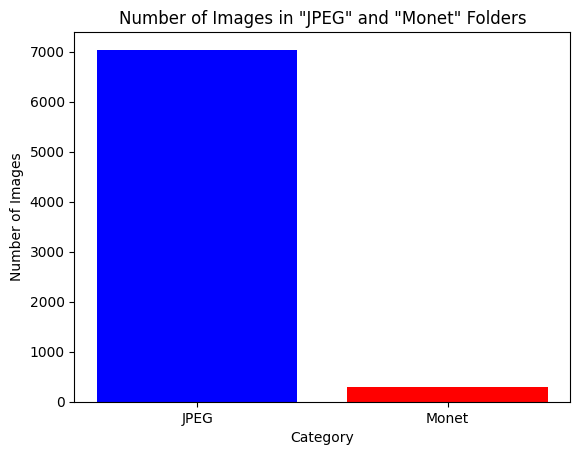

In [15]:
def count_images_in_directory(directory):
    files = os.listdir(directory)
    num_images = 0
    for file in files:
        # Check if the file is an image
        if file.endswith('.jpg'):
            num_images += 1
    return num_images

num_jpeg_images = count_images_in_directory(REAL_IMAGES_PATH)
num_monet_images = count_images_in_directory(MONET_IMAGES_PATH)

# Create a bar graph to visualize the number of images
categories = ['JPEG', 'Monet']
num_images = [num_jpeg_images, num_monet_images]

plt.bar(categories, num_images, color=['blue', 'red'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in "JPEG" and "Monet" Folders')
plt.show()


### Image Visualization

We should examine our image data a little more closely. Checking for images sizes, RGB distribution and pixel value distribution to understand the data a little better.

In [16]:
def analyze_images(directory):
    widths = []
    heights = []
    reds = []
    greens = []
    blues = []

    files = os.listdir(directory)
    for file in files:
        if file.endswith('.jpg'):
            # Open the image using PIL
            img = Image.open(os.path.join(directory, file))

            # Get image dimensions
            width, height = img.size
            widths.append(width)
            heights.append(height)

            # Convert image to numpy array
            img_array = np.array(img)

            # Calculate mean RGB values
            red_mean = np.mean(img_array[:, :, 0])
            green_mean = np.mean(img_array[:, :, 1])
            blue_mean = np.mean(img_array[:, :, 2])

            reds.append(red_mean)
            greens.append(green_mean)
            blues.append(blue_mean)

    return widths, heights, reds, greens, blues

jpeg_widths, jpeg_heights, jpeg_reds, jpeg_greens, jpeg_blues = analyze_images(REAL_IMAGES_PATH)
monet_widths, monet_heights, monet_reds, monet_greens, monet_blues = analyze_images(MONET_IMAGES_PATH)

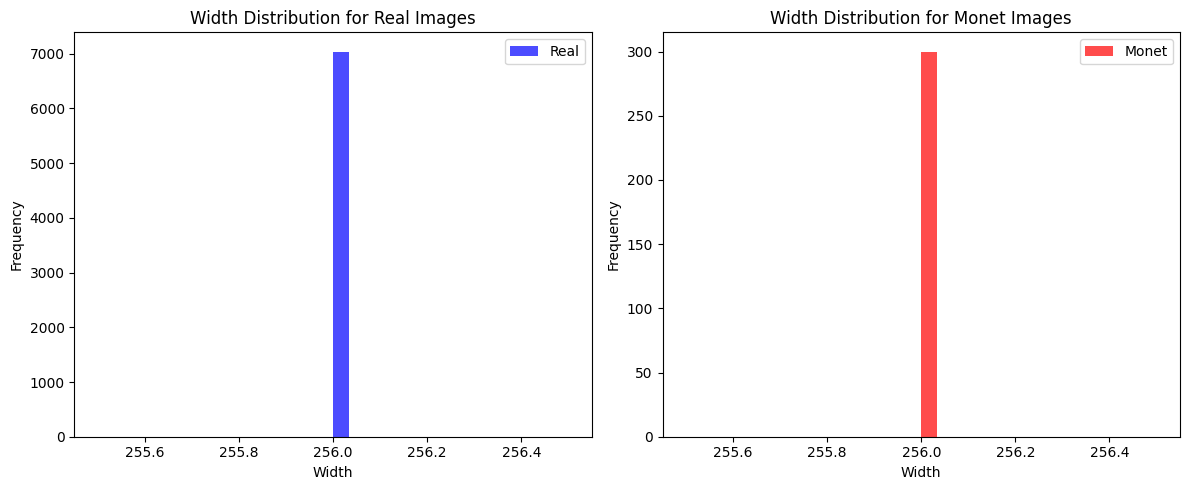

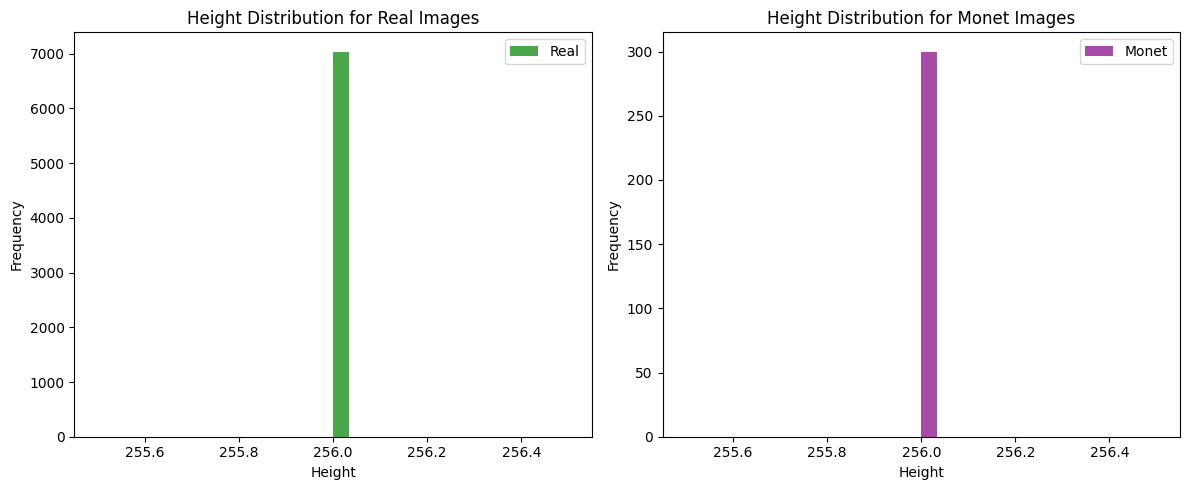

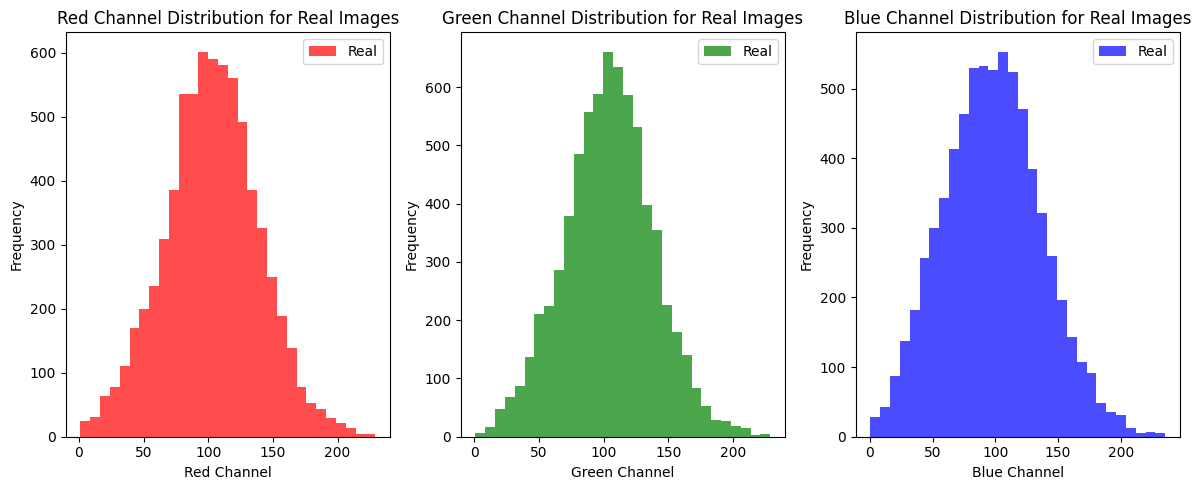

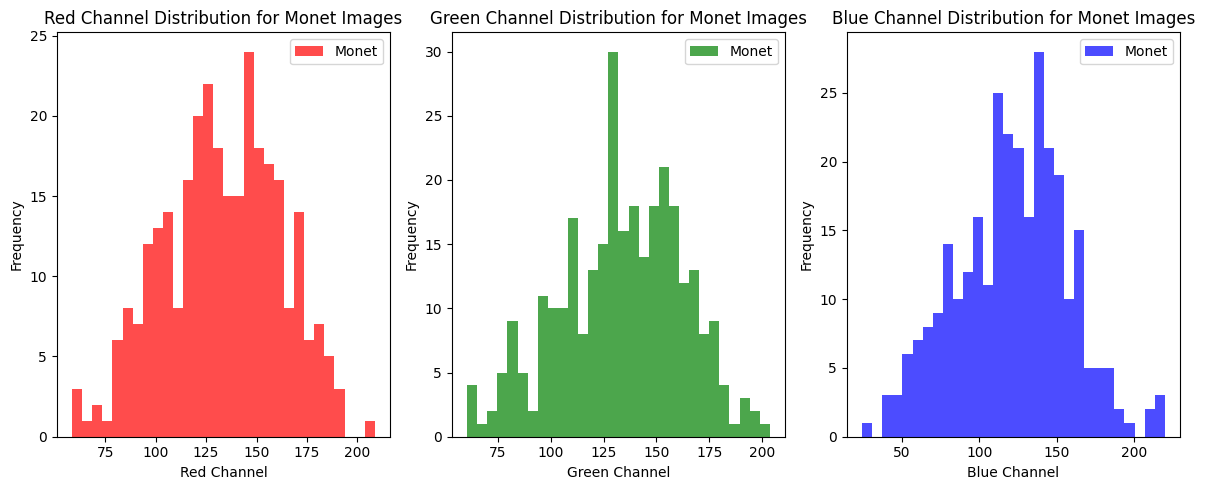

In [17]:
# Plot histograms for width and height separately for "jpeg" and "monet"
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(jpeg_widths, bins=30, color='blue', alpha=0.7, label='Real')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Width Distribution for Real Images')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(monet_widths, bins=30, color='red', alpha=0.7, label='Monet')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Width Distribution for Monet Images')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(jpeg_heights, bins=30, color='green', alpha=0.7, label='Real')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution for Real Images')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(monet_heights, bins=30, color='purple', alpha=0.7, label='Monet')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution for Monet Images')
plt.legend()

plt.tight_layout()
plt.show()

# Plot histograms for RGB channels separately for "jpeg" and "monet"
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.hist(jpeg_reds, bins=30, color='red', alpha=0.7, label='Real')
plt.xlabel('Red Channel')
plt.ylabel('Frequency')
plt.title('Red Channel Distribution for Real Images')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(jpeg_greens, bins=30, color='green', alpha=0.7, label='Real')
plt.xlabel('Green Channel')
plt.ylabel('Frequency')
plt.title('Green Channel Distribution for Real Images')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(jpeg_blues, bins=30, color='blue', alpha=0.7, label='Real')
plt.xlabel('Blue Channel')
plt.ylabel('Frequency')
plt.title('Blue Channel Distribution for Real Images')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.hist(monet_reds, bins=30, color='red', alpha=0.7, label='Monet')
plt.xlabel('Red Channel')
plt.ylabel('Frequency')
plt.title('Red Channel Distribution for Monet Images')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(monet_greens, bins=30, color='green', alpha=0.7, label='Monet')
plt.xlabel('Green Channel')
plt.ylabel('Frequency')
plt.title('Green Channel Distribution for Monet Images')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(monet_blues, bins=30, color='blue', alpha=0.7, label='Monet')
plt.xlabel('Blue Channel')
plt.ylabel('Frequency')
plt.title('Blue Channel Distribution for Monet Images')
plt.legend()

plt.tight_layout()
plt.show()

### Data Pre-Processing

We will load each image folder into a numpy array of images. For each image we will normalize the RGB values from between -1 and 1. This allows us to take advantage of batch normalization or tanh activations functions later. This aids in training with batch normalization because of helps it maintain a zero-mean and unit variance. Where as for tanh activation can suffer from exploding or vanishing gradients when high or low values are used. Centering around 0 helps avoid this.

In [18]:
class UnetGanDataSet:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    def __init__(self, target_style_photo_dir, photo_dir, image_size=[256, 256], channels=3, batch_size=1, verbose=1):
        self.target_style_photo_filenames = tf.io.gfile.glob(str(target_style_photo_dir + '/*.tfrec'))
        self.photo_filenames = tf.io.gfile.glob(str(photo_dir + '/*.tfrec'))
        self.image_size = image_size
        self.channels = channels

        self.target_style_ds = self._load_dataset(self.target_style_photo_filenames).batch(batch_size)
        self.photo_ds = self._load_dataset(self.photo_filenames).batch(batch_size)

        if verbose:
            print("Target Style Photo Files:", len(self.target_style_photo_filenames))
            print("Photo Files:", len(self.photo_filenames))

            print("Target Style Photo Dataset:", self.target_style_ds)
            print("Photo Dataset:", self.photo_ds)

    def _decode_image(self, image):
        image = tf.image.decode_jpeg(image, channels=self.channels)
        image = (tf.cast(image, tf.float32) / 127.5) - 1 # Normalize the images to [-1, 1]
        image = tf.reshape(image, [*self.image_size, self.channels])
        return image

    def _read_tfrecord(self, example):
        tfrecord_format = {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.string)
        }
        image = self._decode_image(
            tf.io.parse_single_example(example, tfrecord_format)['image']
            )
        return image

    def _load_dataset(self, filenames):
        dataset = tf.data.TFRecordDataset(filenames)
        dataset = dataset.map(self._read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset

ds = UnetGanDataSet(MONET_TFREC_IMAGES_PATH, REAL_TFREC_IMAGES_PATH)

Target Style Photo Files: 5
Photo Files: 20
Target Style Photo Dataset: <_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
Photo Dataset: <_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


# U-Net/Cycle GAN Model

The architecture used in this model leverages benefits of U-Net and CycleGAN.

### U-Net
U-Net in relation to GAN works having the encoder progressively down sample an image capturing features and reducing the spatial dimensions. Where as the decoder will progressively reconstruct the target output from an encoded representation. A distinctive feature of U-Net is the use of skip connections between layers of equal resolution in the encoder and decoder. These connections pass feature maps directly from the encoder to the decoder, combining high-level, abstract information with low-level, detailed information. This is particularly useful for tasks where the output needs to closely align with certain aspects of the input.

U-Net in context of GAN can be used as a generator component. In GAN a generator is used to produce an image that is indistinguishable from the real image as judged by the discriminator. When U-Net is used for a generator it can take a noise vector or low resolution image and create a high-fidelity output image. The skip connections allow us to utilize local fine details and global contextual information during image generation.

### CycleGAN

CycleGAN is an architecture that excels at translating data from one domain to another with the need for labelling. In our case translating a normal image to the a stylized monet image. Typically, you would need a dataset where each normal image is directly matched with its Monet-stylized counterpart. CycleGAN eliminates this requirement. 

CycleGAN introduces a concept called cycle consistency loss, which is crucial for maintaining the integrity of the original image content during style transfer. This means that the network not only learns to translate a normal image into a Monet style but also to reverse this process, converting the Monet-styled image back into the original style. This cycle consistency ensures that the translation process preserves the key features and content of the original images, leading to more realistic and coherent stylized results.

In [19]:
class UNet:
    FILTER_MAX = 512
    FILTER_MIN = 64
    KERNAL_SIZE = 4

    def __init__(self, input_shape, output_channels, sample_factor=2):
        self.input_shape = input_shape
        self.output_channels = output_channels
        self.weight_initializer = tf.random_normal_initializer(0., 0.02)
        self.gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.downsample_activation = layers.Activation("leaky_relu")
        self.upsample_activation = layers.Activation("relu")
        self.last_activation = layers.Activation('tanh')
        self.up_sample_dropout_rate = 0.5
        self.sample_factor = sample_factor

    def _downsample(self, filters, kernel_size, use_instance_norm=True):
        """
        Create a downsampling layer.

        Args:
            filters (int): Number of filters for the convolutional layer.
            kernel_size (tuple): Size of the kernel for the convolutional layer.
            down_sample_factor (int): Stride size for downsampling in the convolutional layer.
            use_instance_norm (bool): Whether to include instance normalization. Default is True.

        Returns:
            keras.Sequential: A sequential model representing the downsampling layer.
        """
        model = keras.Sequential()
        model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=self.sample_factor,
                                padding='same', kernel_initializer=self.weight_initializer, use_bias=False))
        if use_instance_norm:
            model.add(tfa.layers.InstanceNormalization(gamma_initializer=self.gamma_initializer))
        model.add(self.downsample_activation)

        return model

    def _upsample(self, filters, kernel_size, dropout = False):
        """
        Create a upsampling layer.

        Args:
            filters (int): Number of filters for the convolutional layer.
            kernel_size (tuple): Size of the kernel for the convolutional layer.
            up_sample_factor (int): Stride size for upsampling in the convolutional layer.
            dropout (bool): Whether to include dropout. Default is False.

        Returns:
            keras.Sequential: A sequential model representing the upsampling layer.
        """
        model = keras.Sequential()
        model.add(layers.Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = self.sample_factor,
                                        padding = 'same',
                                        kernel_initializer = self.weight_initializer,
                                        use_bias = False))
        model.add(tfa.layers.InstanceNormalization(gamma_initializer = self.gamma_initializer))
        if dropout:
            model.add(layers.Dropout(self.up_sample_dropout_rate))
        model.add(self.upsample_activation)

        return model

    def create_generator(self):
        """
        Create a generator model for a GAN.

        Returns:
            keras.Model: The discriminator model.
        """
        inputs = layers.Input(shape=self.input_shape)
        x = inputs

        layer_count = math.log(self.input_shape[0], self.sample_factor)
        downsample_filters = [min(self.FILTER_MIN * (2**i), self.FILTER_MAX) for i in range(int(layer_count))]
        upsample_filters = list(reversed(downsample_filters[:-1]))

        skips = []
        x = self._downsample(downsample_filters[0], self.KERNAL_SIZE, use_instance_norm=False)(x)
        skips.append(x)
        for i in range(1, len(downsample_filters)):
            x = self._downsample(downsample_filters[i], self.KERNAL_SIZE)(x)
            skips.append(x)

        skips = list(reversed(skips[:-1]))
        for i in range(len(upsample_filters)):
            x = self._upsample(upsample_filters[i], self.KERNAL_SIZE)(x)
            x = layers.Concatenate()([x, skips[i]])
        x = layers.Conv2DTranspose(self.output_channels, kernel_size = self.KERNAL_SIZE,
                                   strides = self.sample_factor, padding='same',
                                   kernel_initializer = self.weight_initializer,
                                   activation = self.last_activation)(x)
        return keras.Model(inputs = inputs, outputs = x)

    def create_discriminator(self):
        """
        Create a discriminator model for a GAN.

        Returns:
            keras.Model: The discriminator model.
        """
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Calculate the number of layers based on the input shape and sample factor
        layer_count = int(math.log(self.input_shape[0], self.sample_factor))

        # Create a series of convolutional layers for downsampling
        for i in range(layer_count):
            filters = min(self.FILTER_MIN * (2**i), self.FILTER_MAX)
            if i == 0:
                x = layers.Conv2D(filters, self.KERNAL_SIZE, strides=self.sample_factor, padding='same')(x)
            else:
                x = layers.Conv2D(filters, self.KERNAL_SIZE, strides=self.sample_factor, padding='same',
                                kernel_initializer='he_normal')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization()(x)

        # Flatten and add a dense layer for classification
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)

        return keras.Model(inputs, x)

unet = UNet(input_shape = [256, 256, 3], output_channels = 3)
monet_generator = unet.create_generator()
photo_generator = unet.create_generator()

monet_discriminator = unet.create_discriminator()
photo_discriminator = unet.create_discriminator()

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [21]:
def discriminator_loss(real, generated):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True,
                                                        reduction = tf.keras.losses.Reduction.NONE)

    # Loss for discriminator includes two parts, first where it tries to flag real image as real
    # Second part where it try to minimize flagging generated images as real

    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(generated), generated)

    total_loss = real_loss + fake_loss

    return total_loss*0.5

def generator_loss(generated):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True,
                                                        reduction = tf.keras.losses.Reduction.NONE)
    #For generator we have only one term for loss

    return cross_entropy(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):

    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA*loss1

def identity_loss(real_image, same_image, LAMBDA):

    loss = tf.reduce_mean(tf.abs(real_image - same_image))

    return LAMBDA*0.5*loss

In [22]:
monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)


cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [25]:
history_gan = cycle_gan_model.fit   (
    tf.data.Dataset.zip((ds.target_style_ds, ds.photo_ds)),
    epochs = 25
)

Epoch 1/25
300/300 [==============================] - 79s 264ms/step - monet_gen_loss: 1.8349 - photo_gen_loss: 1.8738 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 2/25
300/300 [==============================] - 79s 264ms/step - monet_gen_loss: 1.8132 - photo_gen_loss: 1.8493 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 3/25
300/300 [==============================] - 79s 264ms/step - monet_gen_loss: 1.7877 - photo_gen_loss: 1.8240 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 4/25
300/300 [==============================] - 79s 263ms/step - monet_gen_loss: 1.7676 - photo_gen_loss: 1.8036 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 5/25
300/300 [==============================] - 79s 263ms/step - monet_gen_loss: 1.7486 - photo_gen_loss: 1.7835 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 6/25
300/300 [==============================] - 79s 263ms/step - monet_gen_loss: 1.7262 - photo_gen_loss: 1.7605 - monet_disc_loss: 0.6931 

In [32]:
# Save the history_gan as a csv file
df = pd.DataFrame(history_gan.history)
df.to_csv(OUTPUT_PATH + "/history_gan.csv", index=False)



# Results and Analysis

Based on the graph of the Generative Adversarial Network (GAN) training history, several observations can be made. Firstly, it appears that the losses for both the Monet and photo generators and discriminators are exhibiting a trend towards stability, albeit with some fluctuations. This suggests a degree of convergence in the training process, indicating that both the generators and discriminators are learning and improving over time. Notably, the generator losses (monet_gen_loss, photo_gen_loss) and discriminator losses (monet_disc_loss, photo_disc_loss) seem to be in a relatively balanced state, which is crucial for the effective training of a GAN. There are no extreme spikes or dips in the loss values, suggesting a stable training process without significant overfitting or underfitting issues. 

However, it's important to note that while these trends are promising, the actual performance of the GAN can only be fully assessed by examining the quality of the generated images and considering additional quantitative metrics beyond these loss values.

Upon closer inspection of the graph depicting the Generative Adversarial Network (GAN) training history, a noteworthy observation is the apparent lack of significant change in the discriminator losses (monet_disc_loss, photo_disc_loss). This consistency in discriminator losses suggests that the discriminators may have quickly reached a point where they are no longer improving significantly, which could be an indication of early convergence or potential limitations in their learning capacity.

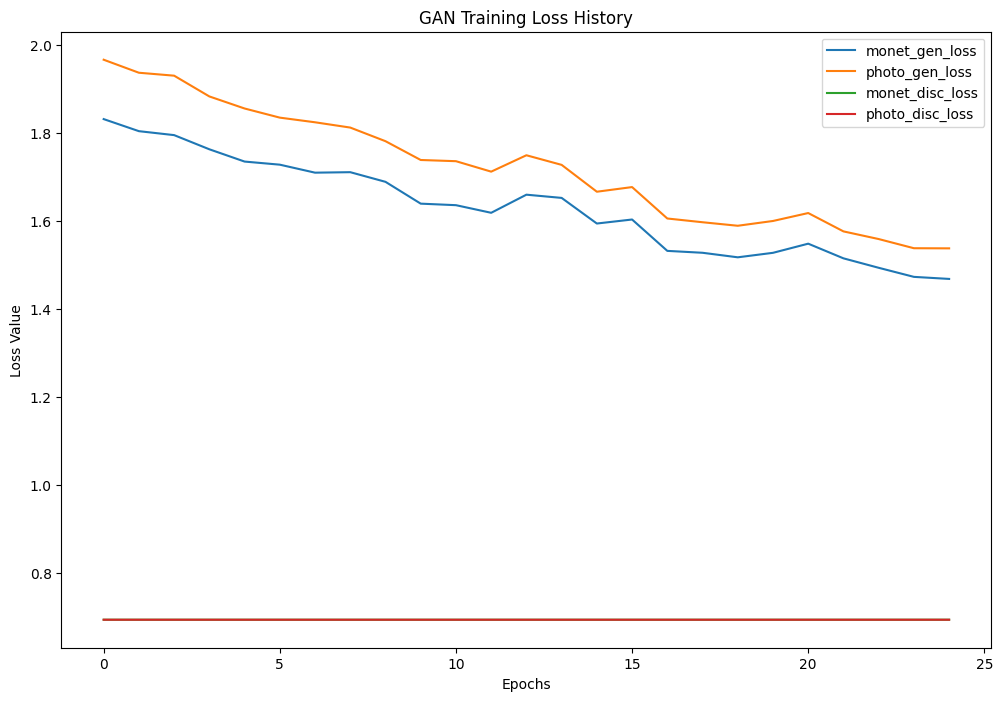

In [35]:
# Load the data from the CSV file
data = pd.read_csv(OUTPUT_PATH + "/history_gan.csv")

# Cleaning the data: removing square brackets and converting strings to floats
data_cleaned = data.apply(lambda x: x.str.strip('[]').astype(float))

# Plotting the data
plt.figure(figsize=(12, 8))

# Plotting each loss type
for column in data_cleaned.columns:
    plt.plot(data_cleaned.index, data_cleaned[column], label=column)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('GAN Training Loss History')
plt.legend()

# Show the plot
plt.show()

In examining the output of the Generative Adversarial Network (GAN) tasked with generating Monet-styled images, it's observed that the 'monetized' images produced by the model do not show significant differences when compared to the original images. This outcome might suggest a few key aspects of the model's current performance. Firstly, it could imply that the generator has not yet learned the complex stylistic nuances typical of Monet's artistry. Instead, it might be reproducing images that are too closely aligned with the input photographs, lacking the distinctive impressionistic flair and color palette that characterize Monet's work. This observation aligns with the relatively stable discriminator losses observed in the training data, indicating that the discriminator might not be effectively challenging the generator to evolve its outputs. 

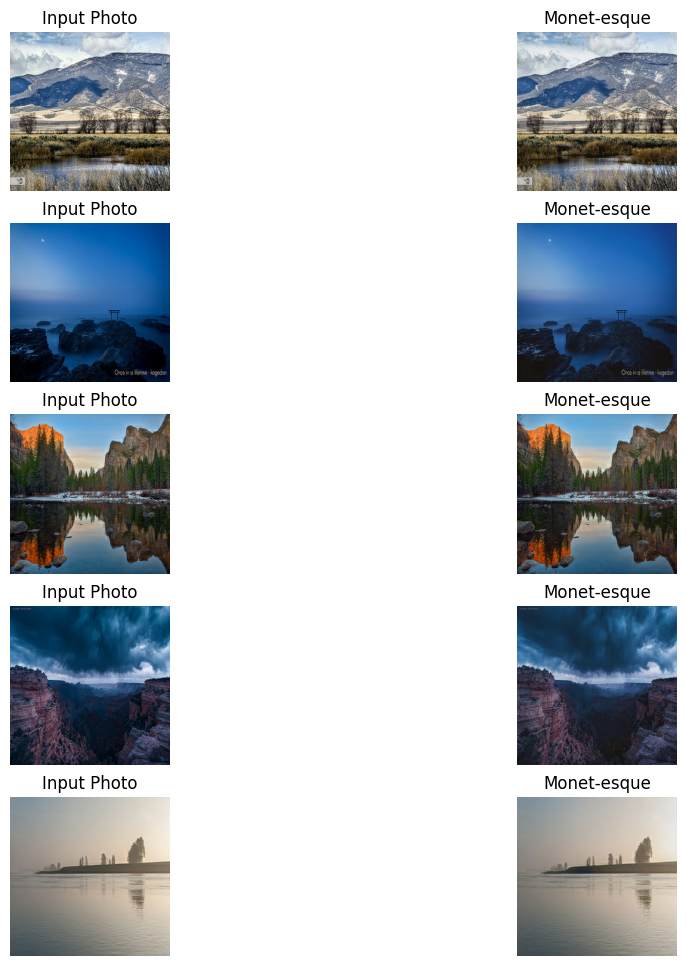

In [34]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(ds.photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion

In conclusion, the analysis of the training history and outputs of the Generative Adversarial Network (GAN) focused on generating Monet-styled images indicates a need for refinement, particularly in enhancing the discriminator's performance to achieve more convincing artistic results. The stable discriminator losses observed during training suggest that the discriminator may not be effectively challenging the generator, resulting in outputs that are too similar to the original photographs and lacking in Monet's distinctive impressionistic style.

To address these issues, several strategies can be employed to improve the discriminator. These include increasing the model's complexity with additional or more densely populated convolutional layers, incorporating dropout layers to prevent overfitting, experimenting with different activation functions like Parametric ReLU or ELU, and adjusting the learning rate to balance the training process. Techniques like spectral normalization and gradient penalty can be introduced to stabilize the training dynamics. Additionally, exploring the use of a conditional discriminator or implementing feature matching to compare intermediate representations can guide the generator towards producing more nuanced images. Adjusting the kernel size and stride in convolutional layers may also help the discriminator in capturing a broader range of features.

By iteratively implementing and evaluating these improvements, the discriminator can become more effective in guiding the generator to produce images that not only replicate the input data but also embody the essence and style of Monet's art. This balanced and enhanced approach is crucial for the development of a GAN capable of creating artistically convincing images that truly reflect the characteristics of Monet's iconic paintings.

# Create a Submission

In [37]:
import PIL
! mkdir ../images

i = 1
for img in ds.photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    print(f"\rImage {i} processed", end="")
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

mkdir: cannot create directory ‘../images’: File exists
Image 7039 processed

'/kaggle/working/images.zip'